In [1]:
import io
import os
import os.path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
from heic2png import HEIC2PNG
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from googleapiclient.http import MediaIoBaseDownload

In [2]:
cd ~/text_recognition/yolov7/

C:\Users\covid\text_recognition\yolov7


In [3]:
!python detect.py --source C:/Users/covid/text_recognition/input/IMG_3965.png --weights yolov7-e6e.pt --conf 0.25 --img-size 1280 --device 0 --save-txt

YOLOR  v0.1-126-g84932d7 torch 2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24575.5MB)


Namespace(weights=['yolov7-e6e.pt'], source='C:/Users/covid/text_recognition/input/IMG_3965.png', img_size=1280, conf_thres=0.25, iou_thres=0.45, device='0', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)


Fusing layers... 

Model Summary: 792 layers, 151687420 parameters, 817020 gradients

 Convert model to Traced-model... 

C:\Users\covid\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)


  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

 traced_script_module saved! 


 model is traced! 

10 books, Done. (54.0ms) Inference, (5.0ms) NMS
 The image with the result is saved in: runs\detect\exp3\IMG_3965.png
Done. (1.200s)


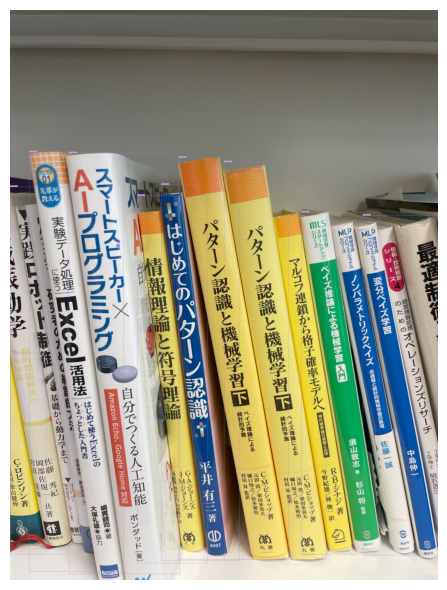

In [4]:
image_path = 'runs/detect/exp/IMG_3965.png'
image = Image.open(image_path)
img = cv2.imread(image_path)
width, height = image.size

# 画像の表示とサイズの変更
plt.figure(figsize=(30, 6))  # 幅8インチ、高さ6インチの図を作成
plt.imshow(image)
plt.axis('off')  # 軸を表示しない

plt.tight_layout()  # 表示領域を調整

plt.show()  # 画像の表示

In [ ]:
# クロップ範囲の指定（ピクセル単位）
left = int(width * 0.0839947)
top = int(height * 0.042328)
right = int(width * 0.342758)
bottom = int(height * 0.773065)

In [ ]:
im = Image.open('./sample.jpg')
    croped = im.crop((318, 224, 493, 398))
    croped.save('./' + 'cake.jpg')

In [ ]:
# 画像のクロップ
cropped_image = image.crop((left, top, right, bottom))

# クロップした画像の保存
cropped_image.save("out_sample1.jpg")

# クロップした画像の表示（OpenCVを使用）
cv2.imshow("cropped", cv2.cvtColor(np.array(cropped_image), cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
SCOPES = ['https://www.googleapis.com/auth/drive.file']
MIME_TYPE = 'application/vnd.google-apps.document'
APPLICATION_NAME = 'ipa-google-drive-api-client'

def get_service():

    # credentialの取得
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'google-drive-api.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
        
    # serviceの取得
    service = build('drive', 'v3', credentials=creds) 
    
    return service

def read_ocr(service, input_file, lang='en'):

    # ファイルのアップロード

    # ローカルファイルの定義
    media_body = MediaFileUpload(input_file, mimetype=MIME_TYPE, resumable=True)

    # Google Drive上のファイル名
    newfile = 'output.pdf'

    body = {
        'name': newfile,
        'mimeType': MIME_TYPE
    }

    # 　creat関数でファイルアップロード実行
    # 同時にOCR読み取りも行う
    output = service.files().create(
        body=body,
        media_body=media_body,
        # ここで読み込み先言語の指定を行う
        ocrLanguage=lang,
    ).execute()

    # テキストファイルのダウンロード

    # リクエストオブジェクト生成
    request = service.files().export_media(
        fileId=output['id'],
        mimeType = "text/plain"
    )

    #  出力用テキストファイル名
    output_path = 'output.txt'

    fh = io.FileIO(output_path, "wb")
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()

    # Google Drive上のファイル削除
    service.files().delete(fileId=output['id']).execute()
 
    # テキストの取得
    with open(output_path) as f:
        mylist = f.read().splitlines()[1:]

    return mylist

service = get_service()

In [2]:
#heic2png(要は拡張子変更)
if __name__ == '__main__':

    file_path = 'input/IMG_3926.heic'
    if os.path.splitext(file_path)[1].lower() == '.heic':
        png_imgfile = HEIC2PNG(file_path)
        png_imgfile.save()  # it'll save as (samename).png

In [3]:
# コンフィグ
COMPRESS_QUALITY = 90 # 圧縮のクオリティ⇒15MB低度なら調節不要だけど随時、、、
# ファイル名を取得
file_name = os.path.splitext(os.path.basename(file_path))[0]
with open(file_path, 'rb') as inputfile:
    # バイナリモードファイルをPILイメージで取得
    im = Image.open(inputfile)
    # JPEG形式に変換して、圧縮を実行
    im = im.convert('RGB')
    im_io = BytesIO()
    im.save(im_io, 'JPEG', quality = COMPRESS_QUALITY)
with open('comp.jpg', mode='wb') as outputfile:
    # 出力ファイル(comp_png_image.png)に書き込み
    outputfile.write(im_io.getvalue())

In [4]:
# 日本語の場合

input_file = outputfile.name ##bufferwriter型からパスを取得
output = read_ocr(service, input_file, 'ja')

UnicodeDecodeError: 'cp932' codec can't decode byte 0xef in position 0: illegal multibyte sequence